In [1]:
%matplotlib notebook
import numpy as np
import scipy
import pymc3 as pm
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

from business_bayes import poisson_switchpoint

## Switchpoint report utility

Just plug in your variables:
* `counts` timeseries of counts
* `prior_lambda`: parameter for exponential prior for the Poisson rate, the `prior_lambda` is a rate (not scale) parameter, ie the expected value for the exponential is `1 / prior_lambda`

and run `Kernel->Restart & Run all` to get the report.

In [2]:
counts = [89, 90, 87, 93, 4, 3, 2, 3, 2, 1]
prior_lambda = 1/10.

### Model

The switchpoint k is drawn from a uniform categorical distribution over indices; counts before $k$ depend on $early\_rate$, counts after $k$ depend on $late\_rate$

* $k \sim \operatorname{Cat}(n, \frac{1}{n})$
* $early\_rate \sim \operatorname{Exponential}(prior\_lambda)$
* $late\_rate \sim \operatorname{Exponential}(prior\_lambda)$
* ${counts}_{i \lt k} \sim \operatorname{Poisson}(early\_rate)$
* ${counts}_{i \geq k} \sim \operatorname{Poisson}(late\_rate)$



### Results

* [Run switchpoint detection model](#Run-switchpoint-detection-model)
* [Trace of switchpoint detection model](#Trace-of-switchpoint-detection-model)
* [Index of the switchpoint](#Index-of-the-switchpoint)
* [Find the rates given the switchpoint](#Find-the-rates-given-the-switchpoint)


#### Run switchpoint detection model

In [3]:
counts = np.array(counts)
switchpoint_model = poisson_switchpoint.make_switchpoint_model(counts, prior_lambda)
with switchpoint_model:
    trace = pm.sample(10000)

/Users/miguelsimon/business_bayes/env/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


#### Trace of switchpoint detection model

* the `switchpoint` variable is the index of the switchpoint.
* the `early_rate` variable is the Poisson rate to the left of the switchpoint (not inclusive).
* the `late_rate` variable is the Poisson rate to the right of the switchpoint.

If the `switchpoint` histogram should look unimodal if a plausible switchpoint has been found by the model.

<IPython.core.display.Javascript object>


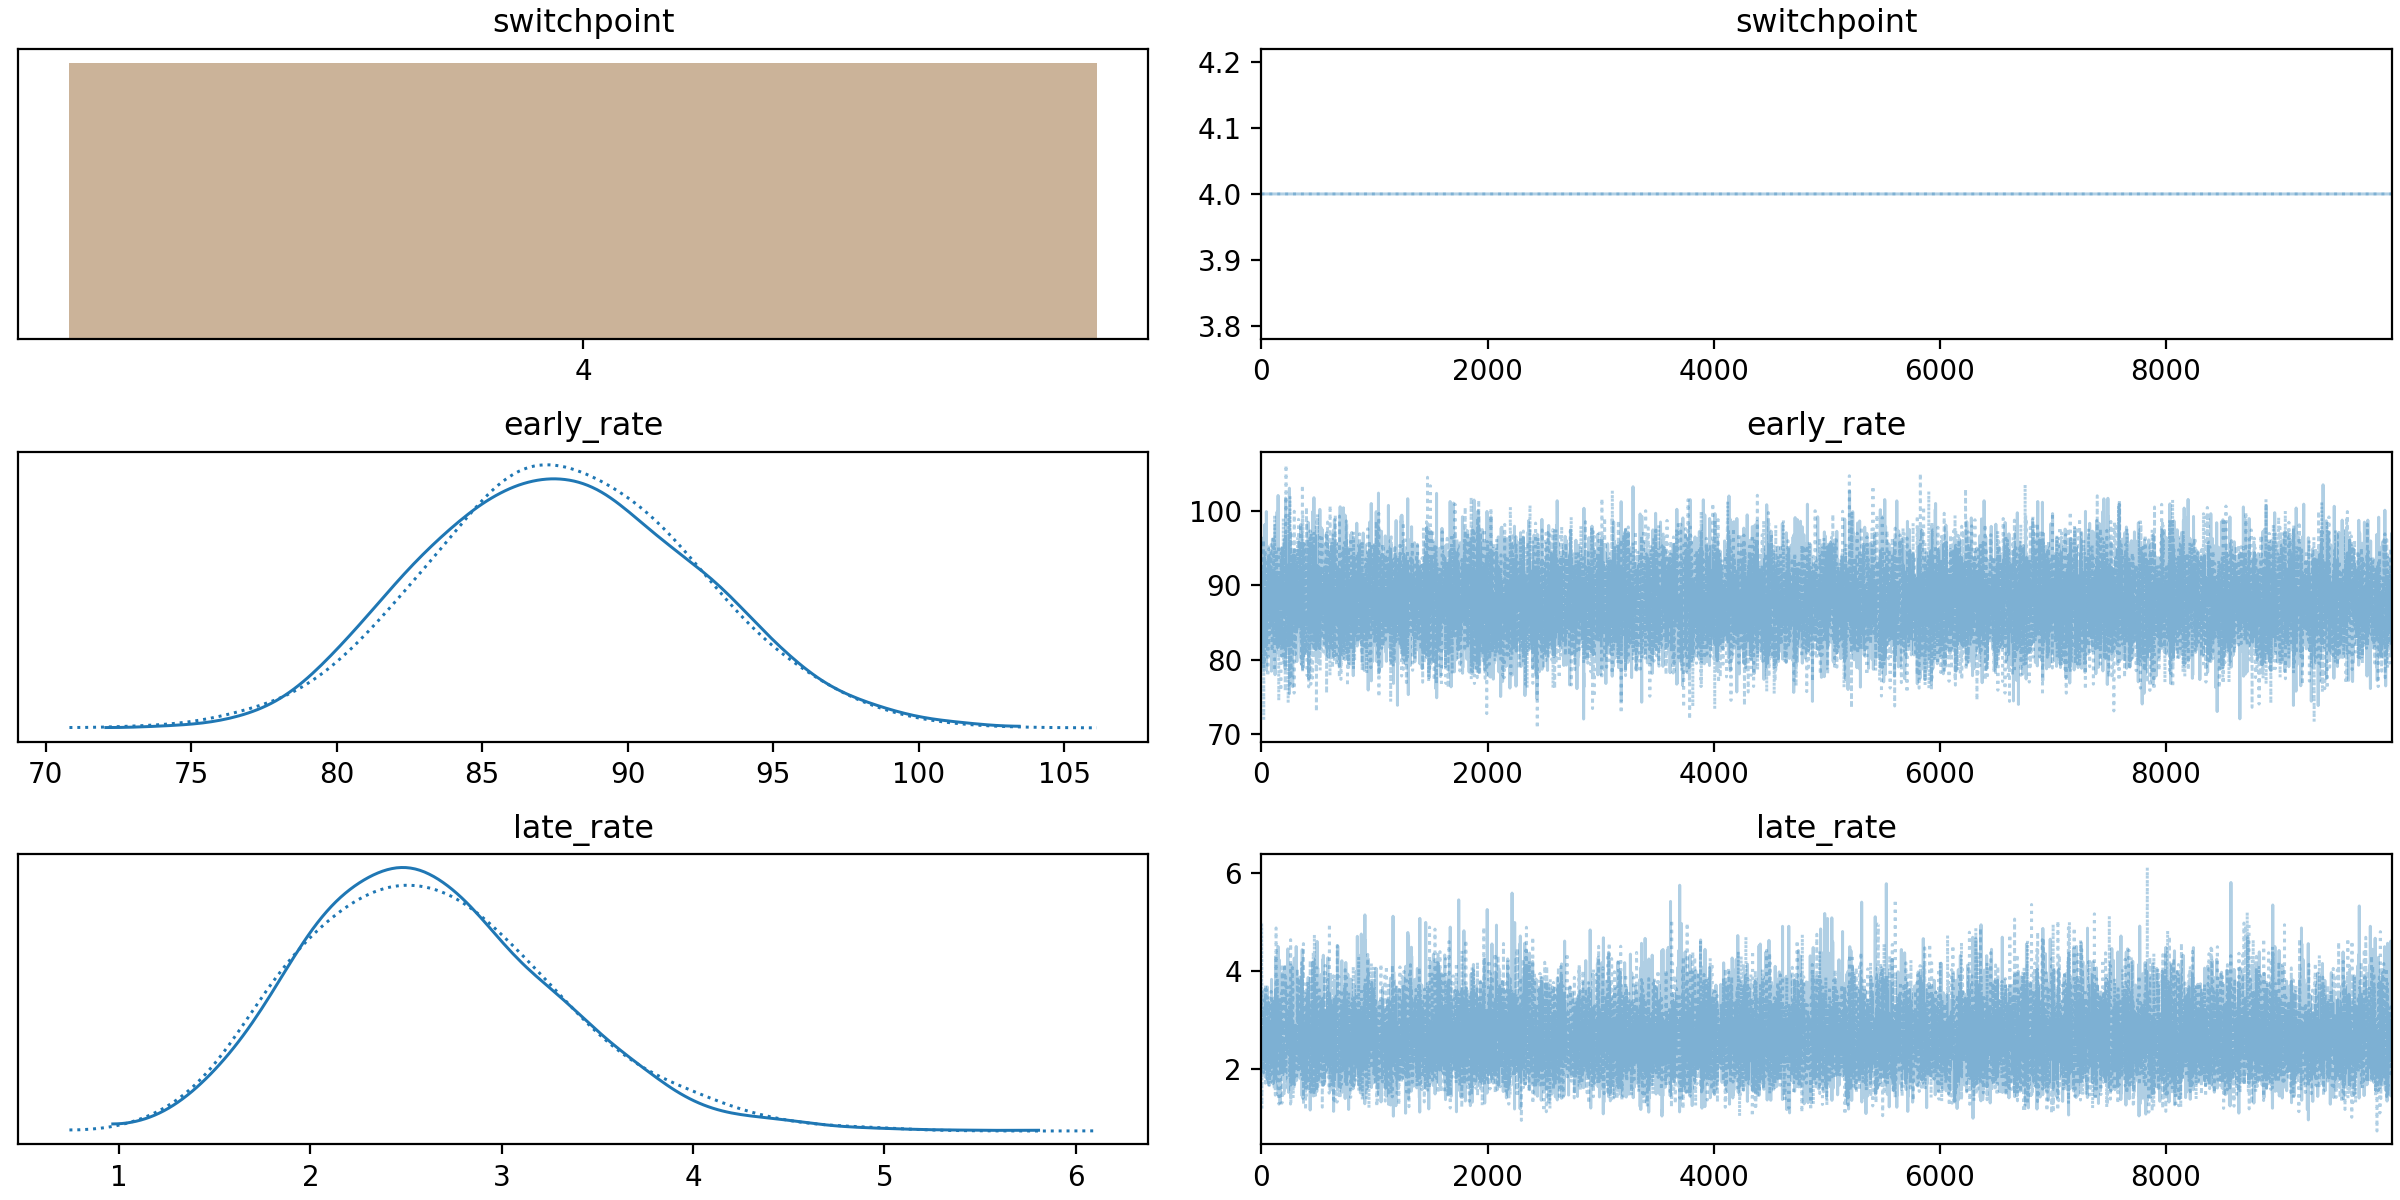

In [4]:
with switchpoint_model:
    pm.traceplot(trace)

#### Index of the switchpoint

We'll choose the mode of the `switchpoint` samples as "the" switchpoint:

In [5]:
switchpoint = scipy.stats.mode(trace["switchpoint"], axis = None).mode[0]
print("SWITCHPOINT INDEX: ", switchpoint)

SWITCHPOINT INDEX:  4


#### Find the rates given the switchpoint

Calculate the densities of: 
* $\mu_1$, Poisson rate to the left of the switchpoint
* $\mu_2$, Poisson rate to the right of the switchpoint
* $k$, the density of the constant that relates them as $\mu_2 = k \cdot \mu_1$

<IPython.core.display.Javascript object>


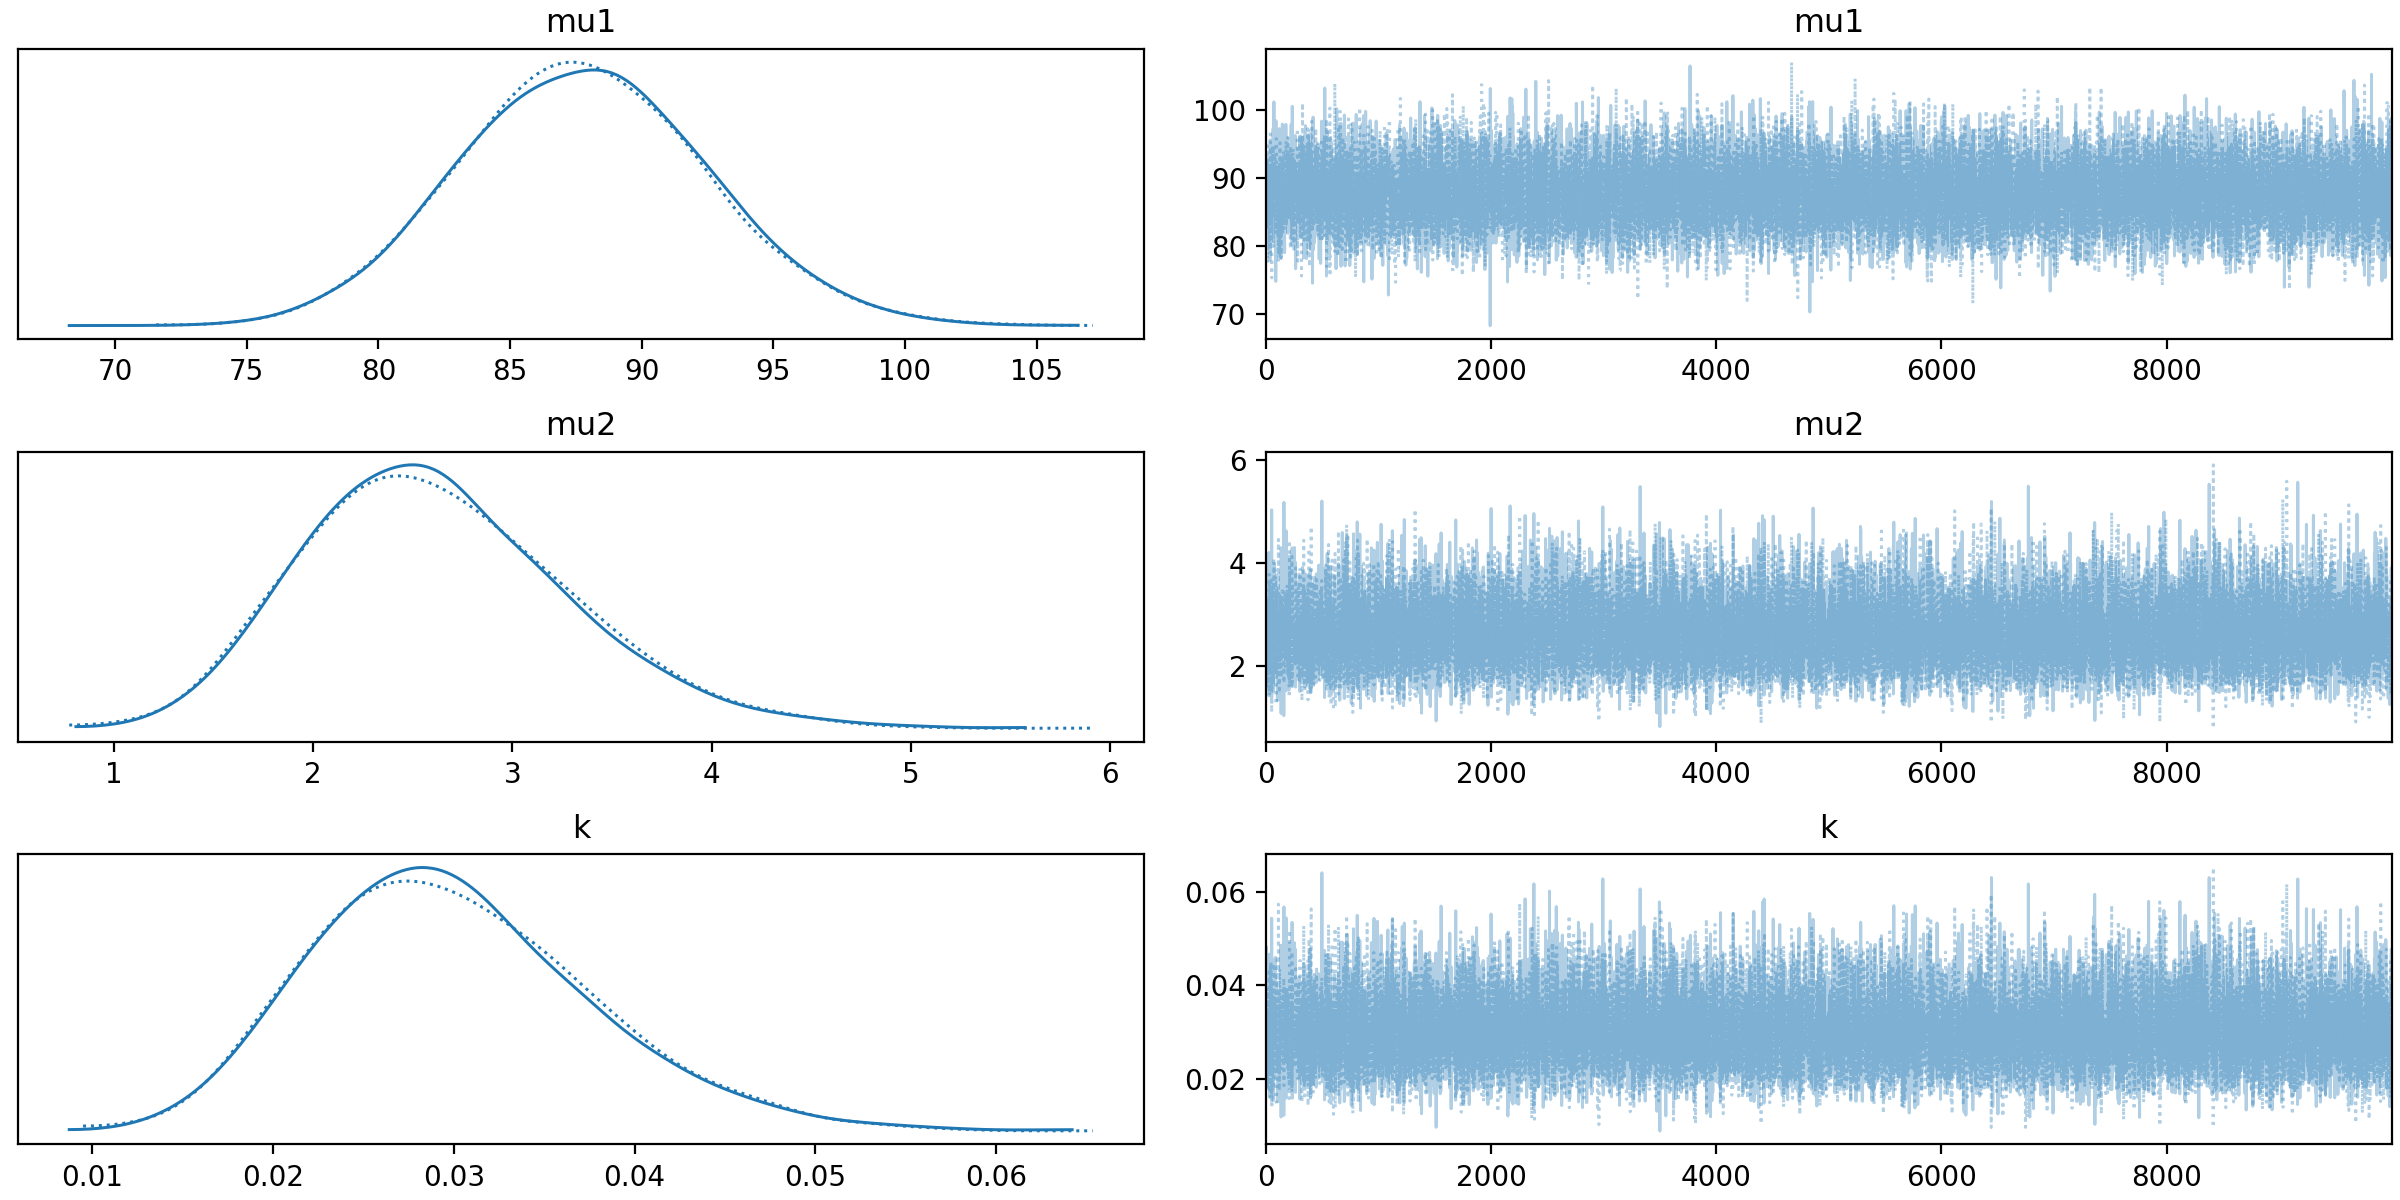

In [6]:
labels = poisson_switchpoint.switchpoint_to_labels(len(counts), switchpoint)
model = poisson_switchpoint.make_2_poisson_model(counts, labels, prior_lambda)

with model:
    rates_trace = pm.sample(10000)
    pm.traceplot(rates_trace)